In [12]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [13]:
train_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = True,
    transform = transforms.ToTensor(),
    download = True
)

test_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

In [14]:
#Data Loader
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = False)

In [15]:
#Define model
class RNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.rnn = nn.LSTM(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        batch_first = True
    )

    self.fc = nn.Linear(self.M, self.K)

  def forward(self, x):
    h0 = torch.zeros(self.L, x.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, x.size(0), self.M).to(device)
    out, _ = self.rnn(x, (h0, c0))
    out = self.fc(out[:, -1, :])
    return out

In [16]:
#Instantiate the model
model = RNN(28, 128, 2, 10)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cuda:0


RNN(
  (rnn): LSTM(28, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)

In [18]:
#Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
#Function to encapsulate the training loop
def  batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1, 28, 28)

      optimizer.zero_grad()

      #Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      #Backward and optimize
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    #Get train loss and test loss
    train_loss = np.mean(train_loss)

    model.eval()
    test_loss = []

    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      inputs = inputs.view(-1, 28, 28)
      #Forward pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    #Save losses
    train_losses[it] = train_loss
    test_losses[it] = test_loss

    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs},  Train Loss: {train_loss:.4f}, \
    Test Loss: {test_loss:.4f}, Duration: {dt} ')
  return train_losses, test_losses


In [20]:
train_losses, test_losses = batch_gd(
    model, criterion, optimizer, train_loader, test_loader, epochs=10
)

Epoch 1/10,  Train Loss: 0.7650,     Test Loss: 0.5874, Duration: 0:00:11.246603 
Epoch 2/10,  Train Loss: 0.4730,     Test Loss: 0.4302, Duration: 0:00:11.270640 
Epoch 3/10,  Train Loss: 0.4081,     Test Loss: 0.4001, Duration: 0:00:11.194549 
Epoch 4/10,  Train Loss: 0.3686,     Test Loss: 0.3821, Duration: 0:00:11.276698 
Epoch 5/10,  Train Loss: 0.3435,     Test Loss: 0.3621, Duration: 0:00:11.281422 
Epoch 6/10,  Train Loss: 0.3258,     Test Loss: 0.3491, Duration: 0:00:11.246841 
Epoch 7/10,  Train Loss: 0.3093,     Test Loss: 0.3371, Duration: 0:00:11.312562 
Epoch 8/10,  Train Loss: 0.2955,     Test Loss: 0.3242, Duration: 0:00:11.227426 
Epoch 9/10,  Train Loss: 0.2826,     Test Loss: 0.3192, Duration: 0:00:11.206564 
Epoch 10/10,  Train Loss: 0.2717,     Test Loss: 0.3185, Duration: 0:00:11.330673 


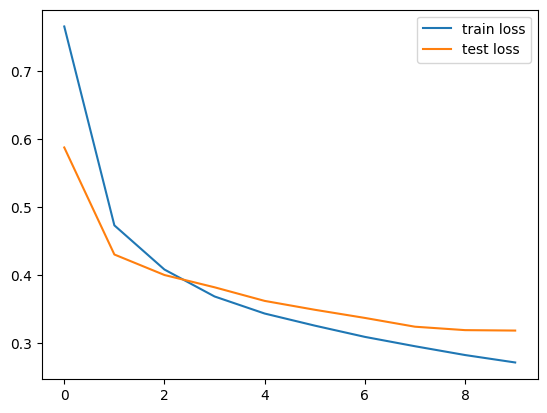

In [21]:
#Plot th train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [22]:
#Accuracy
model.eval()
n_correct = 0.
n_total = 0.

for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 28, 28)
  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)
  inputs = inputs.view(-1, 28, 28)
  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total
print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9037, Test acc: 0.8830


In [ ]:
#Label mapping
labels = """ T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot
""".split('\n')